# Pizza invetory tracking & optimization

### Data Loading and cleaning

In [ ]:
import pandas as pd
import numpy as np
import optuna
from datetime import datetime as dt, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt


# Load the pizza sales data
df = pd.read_excel('Data Model - Pizza Sales.xlsx')
df["order_date"] = pd.to_datetime(df["order_date"])

# Clean ingredient names
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('慛', 'N')
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('Artichokes', 'Artichoke')
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('Anchories', 'Anchovies')
print(f"Data loaded and cleaned with {df.shape[0]} rows and {df.shape[1]} columns.")

c:\Users\nborn\OneDrive\Dokumente\Projekte\TechLabs\restaurant_menu_optimizer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded and cleaned with 48620 rows and 12 columns.


### Inventory constants

In [2]:
#Dictionary with the ingredients and their mass in g per pizza
ingredient_masses_grams = {
    # meats & fish
    "Sliced Ham": 90, "Pepperoni": 80, "Bacon": 70, "Calabrese Salami": 80,
    "Capocollo": 80, "Chicken": 100, "Barbecued Chicken": 100,
    "Prosciutto di San Daniele": 60, "Prosciutto": 60,
    "Beef Chuck Roast": 110, "Italian Sausage": 100, "Chorizo Sausage": 100,
    "Soppressata Salami": 80, "Anchovies": 35,
    "Genoa Salami": 80, "Coarse Sicilian Salami": 80,
    "Luganega Sausage": 100, "Pancetta": 70, "Nduja Salami": 70,
    # cheeses
    "Mozzarella Cheese": 130, "Provolone Cheese": 90, "Smoked Gouda Cheese": 90,
    "Romano Cheese": 25, "Blue Cheese": 60, "Feta Cheese": 70,
    "Asiago Cheese": 70, "Goat Cheese": 60, "Ricotta Cheese": 80,
    "Gorgonzola Piccante Cheese": 60, "Parmigiano Reggiano Cheese": 25,
    "Fontina Cheese": 90, "Gouda Cheese": 90, "Brie Carre Cheese": 60,
    # vegetables & herbs
    "Mushrooms": 70, "Red Onions": 50, "Onions": 50, "Caramelized Onions": 60,
    "Red Peppers": 70, "Green Peppers": 70, "Friggitello Peppers": 40,
    "Jalapeno Peppers": 25, "Peperoncini verdi": 25,
    "Tomatoes": 80, "Plum Tomatoes": 80, "Sun-dried Tomatoes": 35,
    "Spinach": 40, "Arugula": 20, "Artichoke": 70,
    "Zucchini": 70, "Eggplant": 70, "Garlic": 6, "Oregano": 2,
    "Kalamata Olives": 45, "Green Olives": 45, "Pineapple": 80, "Corn": 60,
    "Cilantro": 3, "Pears": 60, "Thyme": 1,
    # sauces
    "Chipotle Sauce": 50, "Barbecue Sauce": 70, "Alfredo Sauce": 80,
    "Pesto Sauce": 50, "Thai Sweet Chilli Sauce": 45, 
}

# Convert to kg for calculations
ingredient_masses_kg = {k: v / 1000 for k, v in ingredient_masses_grams.items()}

print(f"Ingredient masses defined for {len(ingredient_masses_kg)} ingredients")


Ingredient masses defined for 64 ingredients


In [3]:
# Shelf life in days for each ingredient
shelf_life_days = {
    "Sliced Ham": 5, "Pepperoni": 14, "Bacon": 7, "Calabrese Salami": 14,
    "Capocollo": 10, "Chicken": 5, "Barbecued Chicken": 5,
    "Prosciutto di San Daniele": 10, "Prosciutto": 10,
    "Beef Chuck Roast": 5, "Italian Sausage": 7, "Chorizo Sausage": 10,
    "Soppressata Salami": 14, "Anchovies": 30,
    "Genoa Salami": 14, "Coarse Sicilian Salami": 14,
    "Luganega Sausage": 7, "Pancetta": 10, "Nduja Salami": 10,
    "Mozzarella Cheese": 7, "Provolone Cheese": 14, "Smoked Gouda Cheese": 14,
    "Romano Cheese": 30, "Blue Cheese": 10, "Feta Cheese": 7,
    "Asiago Cheese": 14, "Goat Cheese": 7, "Ricotta Cheese": 7,
    "Gorgonzola Piccante Cheese": 10, "Parmigiano Reggiano Cheese": 30,
    "Fontina Cheese": 14, "Gouda Cheese": 14, "Brie Carre Cheese": 7,
    "Mushrooms": 3, "Red Onions": 14, "Onions": 14, "Caramelized Onions": 5,
    "Red Peppers": 5, "Green Peppers": 5, "Friggitello Peppers": 5,
    "Jalapeno Peppers": 7, "Peperoncini verdi": 7,
    "Tomatoes": 5, "Plum Tomatoes": 5, "Sun-dried Tomatoes": 30,
    "Spinach": 3, "Arugula": 3, "Artichoke": 5,
    "Zucchini": 5, "Eggplant": 5, "Garlic": 30, "Oregano": 30,
    "Kalamata Olives": 30, "Green Olives": 30, "Pineapple": 5, "Corn": 7,
    "Cilantro": 3, "Pears": 7, "Thyme": 30,
    "Chipotle Sauce": 30, "Barbecue Sauce": 30, "Alfredo Sauce": 7,
    "Pesto Sauce": 7, "Thai Sweet Chilli Sauce": 30,
}
print(f"Shelf life defined for {len(shelf_life_days)} ingredients")


Shelf life defined for 64 ingredients


In [4]:
#pizza recipes 
df['ingredient_list'] = df['pizza_ingredients'].str.split(',').apply(lambda lst: [ing.strip() for ing in lst])
recipes_dict = df[['pizza_name','ingredient_list']].drop_duplicates('pizza_name').set_index('pizza_name')['ingredient_list'].to_dict()
print(f"There are {len(recipes_dict)} individual pizzas")
recipes_dict

There are 32 individual pizzas


{'The Hawaiian Pizza': ['Sliced Ham', 'Pineapple', 'Mozzarella Cheese'],
 'The Classic Deluxe Pizza': ['Pepperoni',
  'Mushrooms',
  'Red Onions',
  'Red Peppers',
  'Bacon'],
 'The Five Cheese Pizza': ['Mozzarella Cheese',
  'Provolone Cheese',
  'Smoked Gouda Cheese',
  'Romano Cheese',
  'Blue Cheese',
  'Garlic'],
 'The Italian Supreme Pizza': ['Calabrese Salami',
  'Capocollo',
  'Tomatoes',
  'Red Onions',
  'Green Olives',
  'Garlic'],
 'The Mexicana Pizza': ['Tomatoes',
  'Red Peppers',
  'Jalapeno Peppers',
  'Red Onions',
  'Cilantro',
  'Corn',
  'Chipotle Sauce',
  'Garlic'],
 'The Thai Chicken Pizza': ['Chicken',
  'Pineapple',
  'Tomatoes',
  'Red Peppers',
  'Thai Sweet Chilli Sauce'],
 'The Prosciutto and Arugula Pizza': ['Prosciutto di San Daniele',
  'Arugula',
  'Mozzarella Cheese'],
 'The Barbecue Chicken Pizza': ['Barbecued Chicken',
  'Red Peppers',
  'Green Peppers',
  'Tomatoes',
  'Red Onions',
  'Barbecue Sauce'],
 'The Greek Pizza': ['Kalamata Olives',
  'Fet

In [ ]:
# Enhanced Recipe Building with Size-Based Quantities (Adapted from test.ipynb)

def build_detailed_recipes(df, sizes=('S', 'M', 'L')):
    """
    Build detailed recipes with size-based quantities and dough included
    Adapted from test.ipynb methodology
    """
    size_mult = {'S': 0.7, 'M': 1.0, 'L': 1.4}
    dough_by_size = {'S': 180, 'M': 260, 'L': 350}  # grams

    # Override quantities for specific ingredients (grams per medium pizza)
    cheese_overrides = {
        'Mozzarella Cheese': 120, 'Provolone Cheese': 60, 'Smoked Gouda Cheese': 60, 'Romano Cheese': 40,
        'Blue Cheese': 40, 'Brie Carre Cheese': 50, 'Fontina Cheese': 60, 'Gouda Cheese': 60,
        'Asiago Cheese': 50, 'Parmigiano Reggiano Cheese': 25, 'Ricotta Cheese': 60, 'Feta Cheese': 60,
        'Goat Cheese': 50, 'Gorgonzola Piccante Cheese': 50
    }
    sauce_overrides = {
        'Barbecue Sauce': 50, 'Alfredo Sauce': 60, 'Pesto Sauce': 40, 'Chipotle Sauce': 40, 'Thai Sweet Chilli Sauce': 40
    }
    meat_overrides = {
        'Pepperoni': 70, 'Bacon': 50, 'Chicken': 90, 'Prosciutto': 40, 'Sliced Ham': 50, 'Chorizo Sausage': 80,
        'Italian Sausage': 80, 'Pancetta': 40, 'Calabrese Salami': 80, 'Capocollo': 70, 'Genoa Salami': 70,
        'Soppressata Salami': 80, 'Coarse Sicilian Salami': 80, 'Luganega Sausage': 80, 'Barbecued Chicken': 90,
        'Beef Chuck Roast': 90, 'Prosciutto di San Daniele': 40, 'Nduja Salami': 70
    }
    veg_overrides = {
        'Tomatoes': 60, 'Plum Tomatoes': 60, 'Red Peppers': 40, 'Green Peppers': 40, 'Red Onions': 30, 'Onions': 30,
        'Mushrooms': 70, 'Spinach': 40, 'Corn': 40, 'Artichoke': 40, 'Eggplant': 60, 'Zucchini': 40,
        'Pineapple': 80, 'Jalapeno Peppers': 25, 'Green Olives': 30, 'Kalamata Olives': 30, 'Sun-dried Tomatoes': 25,
        'Cilantro': 5, 'Arugula': 20, 'Pears': 50, 'Peperoncini verdi': 20, 'Anchovies': 15, 'Garlic': 5,
        'Caramelized Onions': 30, 'Oregano': 2, 'Thyme': 1, 'Friggitello Peppers': 25
    }

    def get_base_qty(ing: str) -> int:
        """Get base quantity for medium pizza in grams"""
        ing = ing.strip()
        if ing in cheese_overrides:
            return cheese_overrides[ing]
        if ing in sauce_overrides:
            return sauce_overrides[ing]
        if ing in meat_overrides:
            return meat_overrides[ing]
        if ing in veg_overrides:
            return veg_overrides[ing]
        
        # Fallback logic for unspecified ingredients
        ing_lower = ing.lower()
        if 'cheese' in ing_lower:
            return 80
        if 'sauce' in ing_lower or any(k in ing_lower for k in ['chipotle', 'pesto', 'alfredo', 'thai', 'barbecue']):
            return 50
        for meat_keyword in ['chicken', 'bacon', 'salami', 'sausage', 'pepperoni', 'ham', 'prosciutto', 'beef', 'pancetta', 'capocollo']:
            if meat_keyword in ing_lower:
                return 70
        for veg_keyword in ['pepper', 'tomato', 'mushroom', 'onion', 'spinach', 'corn', 'artich', 'eggplant', 'pineapple', 'olive', 'cilantro', 'zucchini', 'pear', 'anchovi']:
            if veg_keyword in ing_lower:
                return 40
        if 'garlic' in ing_lower:
            return 5
        return 30  # default fallback

    # Extract unique pizza ingredients from the dataset
    pizza_ingredients = (
        df.groupby("pizza_name")["pizza_ingredients"]
          .apply(lambda x: set(", ".join(x).split(", ")))
          .to_dict()
    )

    # Build recipes for each pizza and size
    recipes = {}
    for pizza, ingredients in pizza_ingredients.items():
        recipes[pizza] = {}
        for size in sizes:
            recipes[pizza][size] = {}
            # Add dough
            recipes[pizza][size]['Dough'] = dough_by_size[size]
            # Add ingredients
            for ingredient in sorted(ingredients):
                base_qty = get_base_qty(ingredient)
                size_adjusted_qty = int(round(base_qty * size_mult[size]))
                recipes[pizza][size][ingredient] = size_adjusted_qty
    
    return recipes

# Build the enhanced recipes
print("Building enhanced recipes with size-based quantities...")
enhanced_recipes = build_detailed_recipes(df)

# Display sample recipe
sample_pizza = list(enhanced_recipes.keys())[0]
print(f"\nSample Recipe - {sample_pizza}:")
for size in ['S', 'M', 'L']:
    print(f"  {size} size:")
    for ingredient, quantity in enhanced_recipes[sample_pizza][size].items():
        print(f"    {ingredient}: {quantity}g")

print(f"\nTotal pizzas with recipes: {len(enhanced_recipes)}")
print("Enhanced recipe system ready!")

### Daily pizza demand

In [5]:
# Calculate daily pizza demand
daily_demand_pizzas = df.set_index('order_date').groupby('pizza_name')['quantity'].resample('D').sum().unstack(level=0).fillna(0)
print(f"Daily pizza demand calculated for {len(daily_demand_pizzas)} days")
daily_demand_pizzas


Daily pizza demand calculated for 365 days


pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,7.0,6.0,...,4.0,4.0,1.0,7.0,5.0,2.0,5.0,2.0,8.0,3.0
2015-01-02,9.0,8.0,0.0,0.0,5.0,1.0,2.0,6.0,6.0,3.0,...,4.0,6.0,4.0,6.0,11.0,2.0,8.0,4.0,9.0,5.0
2015-01-03,7.0,8.0,1.0,1.0,12.0,5.0,3.0,5.0,4.0,7.0,...,7.0,7.0,1.0,5.0,4.0,6.0,2.0,2.0,10.0,7.0
2015-01-04,11.0,0.0,2.0,2.0,5.0,5.0,1.0,4.0,4.0,4.0,...,5.0,3.0,0.0,1.0,6.0,3.0,4.0,4.0,5.0,1.0
2015-01-05,2.0,4.0,2.0,0.0,8.0,9.0,2.0,9.0,6.0,5.0,...,3.0,6.0,2.0,4.0,3.0,4.0,2.0,3.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,4.0,5.0,1.0,1.0,3.0,0.0,3.0,8.0,2.0,4.0,...,1.0,4.0,1.0,2.0,4.0,3.0,1.0,1.0,5.0,9.0
2015-12-28,2.0,3.0,1.0,1.0,5.0,2.0,3.0,9.0,2.0,4.0,...,5.0,4.0,5.0,3.0,2.0,2.0,2.0,3.0,6.0,3.0
2015-12-29,4.0,6.0,1.0,2.0,6.0,1.0,1.0,3.0,3.0,3.0,...,3.0,2.0,3.0,1.0,3.0,4.0,0.0,1.0,5.0,1.0


### Daily ingredient demand 

In [6]:
def calculate_daily_ingredient_usage(daily_demand_pizzas, recipes_dict, ingredient_masses_kg): #Returns dataframe ingredient_usage
    """
    Convert daily pizza demand to daily ingredient usage.
    
    Parameters:
    - daily_demand_pizzas: DataFrame with dates as index and pizza names as columns
    - recipes_dict: Dictionary mapping pizza names to their ingredient lists
    - ingredient_masses_kg: Dictionary mapping ingredients to their mass per pizza in kg
    
    Returns:
    - DataFrame with dates as index and ingredients as columns showing daily usage in kg
    """
    
    # Get all unique ingredients from recipes
    all_ingredients = set()
    for ingredients in recipes_dict.values():
        all_ingredients.update(ingredients)
    all_ingredients = sorted(list(all_ingredients))
    
    # Initialize ingredient usage dataframe
    ingredient_usage = pd.DataFrame(index=daily_demand_pizzas.index, columns=all_ingredients, dtype=float).fillna(0.0)
    
    # Calculate daily ingredient usage
    for date in daily_demand_pizzas.index:
        for pizza_name in daily_demand_pizzas.columns:
            pizza_quantity = daily_demand_pizzas.loc[date, pizza_name]
            
            if pizza_quantity > 0 and pizza_name in recipes_dict:
                for ingredient in recipes_dict[pizza_name]:
                    if ingredient in ingredient_masses_kg:
                        total_mass = pizza_quantity * ingredient_masses_kg[ingredient]
                        ingredient_usage.loc[date, ingredient] += total_mass
    
    return ingredient_usage
print('Function created')

Function created


In [7]:
# Calculate daily ingredient usage
daily_ingredient_usage = calculate_daily_ingredient_usage(daily_demand_pizzas, recipes_dict, ingredient_masses_kg)

print(f"Daily ingredient usage calculated: {daily_ingredient_usage.shape}")
print(f"Total ingredients tracked: {len(daily_ingredient_usage.columns)}")
daily_ingredient_usage

Daily ingredient usage calculated: (365, 64)
Total ingredients tracked: 64


,Alfredo Sauce,Anchovies,Artichoke,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,...,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.16,0.070,1.47,0.08,0.77,1.05,0.77,1.1,0.55,0.42,...,0.175,0.36,0.63,0.08,1.20,0.175,0.360,0.000,8.16,0.35
2015-01-02,0.08,0.210,2.17,0.08,0.91,0.98,0.63,0.9,0.77,0.36,...,0.150,0.90,0.54,0.32,1.12,0.105,0.405,0.000,8.00,0.63
2015-01-03,0.40,0.210,2.10,0.14,0.84,0.91,0.49,0.7,0.77,0.24,...,0.100,0.72,0.36,0.08,1.44,0.315,0.450,0.001,6.80,0.70
2015-01-04,0.40,0.175,1.47,0.10,0.70,0.28,0.77,1.1,0.44,0.24,...,0.100,0.36,0.36,0.00,0.84,0.105,0.225,0.002,5.04,0.28
2015-01-05,0.72,0.175,1.47,0.06,1.05,0.91,0.14,0.2,0.22,0.36,...,0.150,0.45,0.54,0.16,0.96,0.175,0.270,0.002,4.72,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.00,0.105,0.77,0.02,0.28,0.91,0.28,0.4,0.33,0.12,...,0.050,0.45,0.18,0.08,0.84,0.105,0.225,0.001,4.32,0.63
2015-12-28,0.16,0.140,0.91,0.10,0.42,0.84,0.14,0.2,0.22,0.12,...,0.050,0.63,0.18,0.40,0.84,0.070,0.270,0.001,4.00,0.35
2015-12-29,0.08,0.140,0.98,0.06,0.21,0.63,0.28,0.4,0.22,0.18,...,0.075,0.36,0.27,0.24,0.60,0.175,0.225,0.001,3.04,0.07


### Calculation of initial Inventory parameters

In [26]:
def calculate_initial_inventory_parameters(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
    """
    Calculate all inventory parameters for each ingredient according to specifications:
    - Initial stock: Total demand in first 2 weeks * 2.2
    - Maximum stock: Max daily demand in first 3 months * 0.95
    - Minimum stock: Max daily demand in first 3 months (manually triggered)
    - Shelf life: From predefined dictionary
    
    Parameters:
    - daily_ingredient_usage: DataFrame with daily ingredient usage in kg
    - ingredient_masses_kg: Dictionary with ingredient masses per pizza in kg
    - shelf_life_days: Dictionary with shelf life for each ingredient in days
    
    Returns:
    - DataFrame with all inventory parameters
    """
    
    # Filter first two weeks for initial stock calculation
    first_two_weeks = daily_ingredient_usage[
        (daily_ingredient_usage.index >= '2015-01-01') & 
        (daily_ingredient_usage.index < '2015-01-15')
    ]
    
    # Filter first three months for max/min stock calculation
    first_three_months = daily_ingredient_usage[
        (daily_ingredient_usage.index >= '2015-01-01') & 
        (daily_ingredient_usage.index < '2015-04-01')
    ]
    
    # Calculate parameters for each ingredient
    inventory_parameters = []
    
    for ingredient in daily_ingredient_usage.columns:
        # Initial stock: total demand in first 2 weeks * 2.2
        initial_stock = first_two_weeks[ingredient].sum() * 2.2
        
        # Maximum stock: max daily demand in first 3 months * 0.95
        max_daily_demand = first_three_months[ingredient].max()
        max_stock = max_daily_demand * 0.95
        
        # Minimum stock: same as max daily demand (manually triggered)
        min_stock = max_daily_demand*0.5
        
        # Shelf life
        shelf_life = shelf_life_days.get(ingredient, 7)  # default 7 days
        
        inventory_parameters.append({
            'ingredient': ingredient,
            'initial_stock_kg': initial_stock,
            'max_stock_kg': max_stock,
            'min_stock_kg': min_stock,
            'shelf_life_days': shelf_life,
            'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
        })
    
    return pd.DataFrame(inventory_parameters).set_index('ingredient')

# Calculate inventory parameters
inventory_parameters = calculate_initial_inventory_parameters(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)

print("Inventory parameters calculated:")
print(inventory_parameters)
print(f"\nTotal ingredients: {len(inventory_parameters)}")


Inventory parameters calculated:
                         initial_stock_kg  max_stock_kg  min_stock_kg  \
ingredient                                                              
Alfredo Sauce                      8.0960       0.68400        0.3600   
Anchovies                          4.3890       0.29925        0.1575   
Artichoke                         47.1240       2.79300        1.4700   
Arugula                            2.6400       0.19000        0.1000   
Asiago Cheese                     23.4080       1.33000        0.7000   
...                                   ...           ...           ...   
Sun-dried Tomatoes                 4.7740       0.39900        0.2100   
Thai Sweet Chilli Sauce            8.9100       0.55575        0.2925   
Thyme                              0.0286       0.00475        0.0025   
Tomatoes                         193.7760       7.90400        4.1600   
Zucchini                          16.4780       0.99750        0.5250   

                 

### Invetory simulation function

In [27]:
def simulate_inventory(df, inventory_parameters, recipes_dict, ingredient_masses_kg, 
                      start_date='2015-01-01', end_date='2015-04-01',
                      restock_interval_days=7, alarm_threshold=3):
    """
    Simulate inventory management over a date range with given parameters.
    
    Structure of the function:
        1.prepare dates and a working copy of sales data
        2.read initial inventoryparameters as plain dicts
        3.initialize inventory structure by ingredient with initial stock and expiry dates
        4.setting up tracking variables
        5.define helper functions for stock checking, expiry removal, and FEFO consumption
        6.run the main simulation loop day by day:
            a) remove expired stock and account for waste
            b) fulfill orders of the day using FEFO
            c) check for manual low-stock alarms
            d) check for restock events (weekly and interval-based)
            e) adjust restock interval based on weekly alarms
        7.return a summary of results

    - Inputs:
        - df: DataFrame with pizza orders (order_date, pizza_name, quantity)
        - inventory_parameters: DataFrame with initial, min, max stock and shelf life
        - recipes_dict: Dictionary mapping pizza names to their ingredient lists
        - ingredient_masses_kg: Dictionary mapping ingredients to their mass per pizza in kg
        - start_date, end_date: Simulation date range
        - restock_interval_days: Days between automatic restocks
        - alarm_threshold: Weekly alarms needed to shorten restock interval
    
    Outputs: Dict with simulation results
    
    Features:
        - FEFO consumption
        - Weekly + interval restocks
        - Weekly alarm threshold shortens interval
        - Counts safety_stock_alarms
    
    Returns a dict with: lost_demand, waste_kg (per ingredient), waste_total_kg,
    restock_events, final_restock_interval_days, safety_stock_alarms
    """

    #prepare dates and a copy of original df sales
    df_sim = df.copy()
    df_sim["date"] = pd.to_datetime(df_sim["order_date"]).dt.date
    days = pd.date_range(start_date, end_date, freq="D").date
    start_day = days[0]

    #input parameters as plain dicts
    min_stock   = {k: float(v) for k, v in inventory_parameters['min_stock_kg'].items()}
    max_stock   = {k: float(v) for k, v in inventory_parameters['max_stock_kg'].items()}
    shelf_life  = {k: int(v)   for k, v in inventory_parameters['shelf_life_days'].items()}

    #structure of the inventory: {ingredient: [(amount_kg, expiry_date)]}
    inventory = {}
    for ing in inventory_parameters.index: 
        init_amt = float(inventory_parameters.loc[ing, 'initial_stock_kg']) #take initial stock from parameters dataframe column
        exp_date = start_day + timedelta(days=int(inventory_parameters.loc[ing, 'shelf_life_days'])) # use start day of simulation + shelf life days as expiry date for initial stock
        inventory[ing] = [(init_amt, exp_date)] 

    #tracking variables and dictionaries
    lost_demand = 0 
    waste = defaultdict(float) #defaultdict is a dictionary that provides a default value for yet non-existing keys
    weekly_alarms = 0 #weekly alarms counter
    safety_stock_alarms = 0 #total safety stock alarms counter
    restock_events = 0 #total restock events counter
    current_restock_interval = int(restock_interval_days) #make the interval int (full days only)
    week_start = start_day #start of the current week for alarm counting

    #helpful functions
    def get_current_stock(ingredient):
        total = 0.0 
        for amt, _ in inventory.get(ingredient, []):   #actual stock of an ingredient, which is not spoiled 
            total += float(amt) #sum up all amounts of all batches
        return float(total) #return total stock of an ingredient

    def remove_expired(today):
        for ing in list(inventory.keys()): #list() to avoid "dictionary changed size during iteration" error, which happend before
            new_batches = [] #batches that are still good after removing expired ones
            for amt, exp in inventory[ing]: #check all batches of an ingredient
                if today >= exp: #current date bigger or equal to expiry date
                    waste[ing] += float(amt) #put it into waste
                else: #still good, keep it
                    new_batches.append((float(amt), exp)) #keep good batches to new_batches
            inventory[ing] = new_batches #update inventory with only good batches

    def consume_fefo(ingredient, needed_amount): 
        # Sort batches by soonest expiry first
        if ingredient not in inventory: 
            return False 
        inventory[ingredient].sort(key=lambda t: t[1]) #t[1] is the expiry date

        remaining_need = float(needed_amount) #how much we still need to consume
        new_batches = []

        for amt, exp in inventory[ingredient]:
            if remaining_need <= 0:
                new_batches.append((amt, exp))
                continue
            use = min(float(amt), remaining_need)
            left = float(amt) - use
            remaining_need -= use
            if left > 1e-9:
                new_batches.append((left, exp))

        inventory[ingredient] = new_batches
        return remaining_need <= 1e-9

    #daily simulation loop
    for day in days:
        remove_expired(day) #throw out expired food

        #fulfil orders of the day
        day_orders = df_sim[df_sim["date"] == day]
        for _, order in day_orders.iterrows():
            pizza = order['pizza_name']
            qty = int(order['quantity'])

            if pizza not in recipes_dict:
                continue

            #needed ingredient amounts for fulfilling the order
            needed = {}
            can_fulfill = True
            for ing in recipes_dict[pizza]:
                amt_needed = float(qty) * float(ingredient_masses_kg[ing])
                needed[ing] = amt_needed
                if get_current_stock(ing) < amt_needed:
                    can_fulfill = False
                    break

            if can_fulfill:
                #Consume all needed ingredients using FEFO
                for ing, amt_needed in needed.items():
                    ok = consume_fefo(ing, amt_needed)
                    if not ok:
                        can_fulfill = False
                        break

            if not can_fulfill:
                lost_demand += 1

        # 3) Manual low-stock alarms
        for ing in list(inventory.keys()):
            curr = get_current_stock(ing)
            thr = float(min_stock.get(ing, 0.0))
            if curr <= thr:
                weekly_alarms += 1
                safety_stock_alarms += 1

        #checks if restock day is here
        restock_today = False

        # Weekly Monday restock 
        if day.weekday() == 0:
            restock_today = True

        # Interval-based restock from start day
        days_since_start = (day - start_day).days
        if days_since_start % current_restock_interval == 0:
            restock_today = True

        if restock_today:
            restock_events += 1
            for ing in inventory_parameters.index:
                target = float(max_stock.get(ing, 0.0))
                curr = get_current_stock(ing)
                add = max(0.0, target - curr)
                if add > 0.0:
                    exp = day + timedelta(days=int(shelf_life.get(ing, 7)))
                    inventory[ing].append((add, exp))

        # 5) Weekly interval adjustment
        if day >= week_start + timedelta(days=6):
            if weekly_alarms >= int(alarm_threshold):
                current_restock_interval = max(3, current_restock_interval - 1)
            weekly_alarms = 0
            week_start = day + timedelta(days=1)

    return {
        'lost_demand': int(lost_demand),
        'waste_kg': dict(waste),
        'waste_total_kg': round(float(sum(waste.values())), 3),
        'restock_events': int(restock_events),
        'final_restock_interval_days': int(current_restock_interval),
        'safety_stock_alarms': int(safety_stock_alarms)
    }


### Testing of Simulation function

In [28]:
# === Run simulations with different restock intervals ===
restock_intervals = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
simulation_results = []

for interval in restock_intervals:
    result = simulate_inventory(
        df=df,
        inventory_parameters=inventory_parameters,
        recipes_dict=recipes_dict,
        ingredient_masses_kg=ingredient_masses_kg,
        start_date='2015-01-01',
        end_date='2015-03-31',
        restock_interval_days=interval,
        alarm_threshold=3
    )
    result['restock_interval_days'] = interval
    simulation_results.append(result)

# turn into DataFrame
results_df = pd.json_normalize(simulation_results)
results_df = results_df.set_index("restock_interval_days").sort_index()

# expand waste_kg dict into columns
if "waste_kg" in results_df.columns:
    waste_df = pd.DataFrame(results_df.pop("waste_kg").tolist(),
                            index=results_df.index).add_prefix("waste_kg_")
    results_df = results_df.join(waste_df)

# show selected outputs
print("Simulation Results:")
print(results_df[["lost_demand","waste_total_kg","restock_events",
                  "safety_stock_alarms","final_restock_interval_days"]])


Simulation Results:
                       lost_demand  waste_total_kg  restock_events  \
restock_interval_days                                                
3                             5437        1179.480              39   
4                             5564        1206.129              37   
5                             5390        1174.572              38   
6                             5474        1214.077              38   
7                             5902        1228.743              35   
8                             6498        1239.691              31   
9                             6036        1228.597              34   
10                            6108        1235.285              33   
11                            7016        1266.295              29   
12                            6563        1252.672              30   

                       safety_stock_alarms  final_restock_interval_days  
restock_interval_days                                            

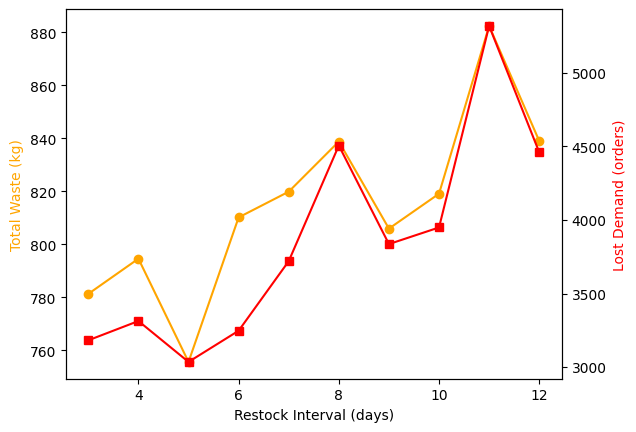

In [18]:
fig, ax = plt.subplots()

# Waste on left y-axis
ax.plot(results_df.index, results_df['waste_total_kg'], 'o-', color='orange')
ax.set_xlabel('Restock Interval (days)')
ax.set_ylabel('Total Waste (kg)', color='orange')

# Lost demand on right y-axis
ax2 = ax.twinx()
ax2.plot(results_df.index, results_df['lost_demand'], 's-', color='red')
ax2.set_ylabel('Lost Demand (orders)', color='red')

plt.show()

In [15]:
# Multi-Alpha Optimization Analysis
import matplotlib.pyplot as plt
import seaborn as sns

def objective_with_alpha(trial, alpha):
    """Modified objective function that accepts alpha as parameter"""
    # Suggest factors for initial, min, and max stock
    init_factor = trial.suggest_float('init_factor', 1.0, 3.0)
    min_factor = trial.suggest_float('min_factor', 0.1, 0.9)
    max_factor = trial.suggest_float('max_factor', 0.7, 3.0)

    # Generate new inventory parameters
    def custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
        first_two_weeks = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-01-15')
        ]
        first_three_months = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-04-01')
        ]
        inventory_parameters = []
        for ingredient in daily_ingredient_usage.columns:
            initial_stock = first_two_weeks[ingredient].sum() * init_factor
            max_daily_demand = first_three_months[ingredient].max()
            max_stock = max_daily_demand * max_factor
            min_stock = max_daily_demand * min_factor
            shelf_life = shelf_life_days.get(ingredient, 7)
            inventory_parameters.append({
                'ingredient': ingredient,
                'initial_stock_kg': initial_stock,
                'max_stock_kg': max_stock,
                'min_stock_kg': min_stock,
                'shelf_life_days': shelf_life,
                'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
            })
        return pd.DataFrame(inventory_parameters).set_index('ingredient')

    # Calculate parameters and run simulation
    params = custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)
    result = simulate_inventory(
        df=df,
        inventory_parameters=params,
        recipes_dict=recipes_dict,
        ingredient_masses_kg=ingredient_masses_kg,
        start_date='2015-01-01',
        end_date='2015-04-01',
        restock_interval_days=5,
        alarm_threshold=2
    )
    score = result['lost_demand'] + alpha * result['waste_total_kg']
    return score

def run_optimization_for_alpha_range():
    """Run optimization for different alpha values"""
    # Define alpha range
    alpha_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
    results = []
    
    print("Running optimization for different alpha values...")
    
    for alpha in alpha_values:
        print(f"Optimizing for alpha = {alpha}")
        
        # Create study for this alpha
        study = optuna.create_study(direction='minimize')
        
        # Define objective for this specific alpha
        def objective_alpha(trial):
            return objective_with_alpha(trial, alpha)
        
        # Optimize
        study.optimize(objective_alpha, n_trials=50)
        
        # Get best parameters
        best_params = study.best_params
        best_score = study.best_value
        
        # Run simulation with best parameters to get detailed results
        def custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
            first_two_weeks = daily_ingredient_usage[
                (daily_ingredient_usage.index >= '2015-01-01') & 
                (daily_ingredient_usage.index < '2015-01-15')
            ]
            first_three_months = daily_ingredient_usage[
                (daily_ingredient_usage.index >= '2015-01-01') & 
                (daily_ingredient_usage.index < '2015-04-01')
            ]
            inventory_parameters = []
            for ingredient in daily_ingredient_usage.columns:
                initial_stock = first_two_weeks[ingredient].sum() * best_params['init_factor']
                max_daily_demand = first_three_months[ingredient].max()
                max_stock = max_daily_demand * best_params['max_factor']
                min_stock = max_daily_demand * best_params['min_factor']
                shelf_life = shelf_life_days.get(ingredient, 7)
                inventory_parameters.append({
                    'ingredient': ingredient,
                    'initial_stock_kg': initial_stock,
                    'max_stock_kg': max_stock,
                    'min_stock_kg': min_stock,
                    'shelf_life_days': shelf_life,
                    'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
                })
            return pd.DataFrame(inventory_parameters).set_index('ingredient')

        params = custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)
        detailed_result = simulate_inventory(
            df=df,
            inventory_parameters=params,
            recipes_dict=recipes_dict,
            ingredient_masses_kg=ingredient_masses_kg,
            start_date='2015-01-01',
            end_date='2015-04-01',
            restock_interval_days=5,
            alarm_threshold=2
        )
        
        # Store results
        result_data = {
            'alpha': alpha,
            'best_score': best_score,
            'init_factor': best_params['init_factor'],
            'min_factor': best_params['min_factor'],
            'max_factor': best_params['max_factor'],
            'lost_demand': detailed_result['lost_demand'],
            'waste_total_kg': detailed_result['waste_total_kg'],
            'restock_events': detailed_result['restock_events'],
            'safety_stock_alarms': detailed_result['safety_stock_alarms']
        }
        results.append(result_data)
        
        print(f"  Best score: {best_score:.2f}")
        print(f"  Lost demand: {detailed_result['lost_demand']}")
        print(f"  Waste: {detailed_result['waste_total_kg']:.2f} kg")
        print()
    
    return pd.DataFrame(results)

# Run the analysis
alpha_results = run_optimization_for_alpha_range()
print("Alpha optimization complete!")
print("\nSummary of results:")
print(alpha_results)

[I 2025-09-15 16:58:10,258] A new study created in memory with name: no-name-d96f0b53-76bd-463a-b879-9d637ca1ac4d


Running optimization for different alpha values...
Optimizing for alpha = 0.01


[I 2025-09-15 16:58:11,157] Trial 0 finished with value: 3858.91531 and parameters: {'init_factor': 2.0640674466350983, 'min_factor': 0.1992745570329687, 'max_factor': 1.2855425000093672}. Best is trial 0 with value: 3858.91531.
[I 2025-09-15 16:58:12,053] Trial 1 finished with value: 5933.3531 and parameters: {'init_factor': 2.1393687992519883, 'min_factor': 0.15524056679358544, 'max_factor': 0.869000038689397}. Best is trial 0 with value: 3858.91531.
[I 2025-09-15 16:58:12,925] Trial 2 finished with value: 5963.00519 and parameters: {'init_factor': 2.8332005540633425, 'min_factor': 0.5377147479710592, 'max_factor': 0.8652368412726964}. Best is trial 0 with value: 3858.91531.
[I 2025-09-15 16:58:13,863] Trial 3 finished with value: 1975.80998 and parameters: {'init_factor': 2.429232787435786, 'min_factor': 0.5456155078566932, 'max_factor': 2.4883737567089064}. Best is trial 3 with value: 1975.80998.
[I 2025-09-15 16:58:14,786] Trial 4 finished with value: 1913.48306 and parameters: {'

  Best score: 1852.53
  Lost demand: 1842
  Waste: 1053.47 kg

Optimizing for alpha = 0.05


[I 2025-09-15 16:58:58,948] Trial 0 finished with value: 2023.0548 and parameters: {'init_factor': 2.007191291029499, 'min_factor': 0.4751451675102547, 'max_factor': 2.773006926704297}. Best is trial 0 with value: 2023.0548.
[I 2025-09-15 16:58:59,874] Trial 1 finished with value: 3212.1701 and parameters: {'init_factor': 1.4226876233971022, 'min_factor': 0.3400361693447576, 'max_factor': 1.4524015040011187}. Best is trial 0 with value: 2023.0548.
[I 2025-09-15 16:59:00,833] Trial 2 finished with value: 2442.4665 and parameters: {'init_factor': 2.0502054522155158, 'min_factor': 0.2667237676407809, 'max_factor': 1.7555178914959817}. Best is trial 0 with value: 2023.0548.
[I 2025-09-15 16:59:01,782] Trial 3 finished with value: 2045.2806 and parameters: {'init_factor': 2.371942246454144, 'min_factor': 0.1395895787624416, 'max_factor': 2.8342717237165855}. Best is trial 0 with value: 2023.0548.
[I 2025-09-15 16:59:02,723] Trial 4 finished with value: 3083.62595 and parameters: {'init_fact

  Best score: 1902.03
  Lost demand: 1857
  Waste: 900.59 kg

Optimizing for alpha = 0.1


[I 2025-09-15 16:59:47,538] Trial 0 finished with value: 1976.1512 and parameters: {'init_factor': 1.248356561117131, 'min_factor': 0.24586501018058612, 'max_factor': 2.497666036938121}. Best is trial 0 with value: 1976.1512.
[I 2025-09-15 16:59:48,801] Trial 1 finished with value: 2121.2713 and parameters: {'init_factor': 2.3870826683730826, 'min_factor': 0.4506752827275786, 'max_factor': 2.34756710618271}. Best is trial 0 with value: 1976.1512.
[I 2025-09-15 16:59:50,112] Trial 2 finished with value: 2130.2235 and parameters: {'init_factor': 1.7778396533649763, 'min_factor': 0.5373279965465184, 'max_factor': 2.044932898957596}. Best is trial 0 with value: 1976.1512.
[I 2025-09-15 16:59:51,173] Trial 3 finished with value: 2003.2371 and parameters: {'init_factor': 1.469256557265343, 'min_factor': 0.2017793333361933, 'max_factor': 2.6836097020303065}. Best is trial 0 with value: 1976.1512.
[I 2025-09-15 16:59:52,342] Trial 4 finished with value: 2030.9611 and parameters: {'init_factor'

  Best score: 1943.34
  Lost demand: 1846
  Waste: 973.43 kg

Optimizing for alpha = 0.2


[I 2025-09-15 17:00:39,735] Trial 0 finished with value: 2356.5106 and parameters: {'init_factor': 2.8606197415941086, 'min_factor': 0.4985676429073884, 'max_factor': 2.1365485959656887}. Best is trial 0 with value: 2356.5106.
[I 2025-09-15 17:00:40,676] Trial 1 finished with value: 2065.0394 and parameters: {'init_factor': 1.041904718374468, 'min_factor': 0.29397417112913404, 'max_factor': 2.9450710604528156}. Best is trial 1 with value: 2065.0394.
[I 2025-09-15 17:00:41,648] Trial 2 finished with value: 2312.8012 and parameters: {'init_factor': 2.182604317765075, 'min_factor': 0.11100082956258009, 'max_factor': 2.9966100572159613}. Best is trial 1 with value: 2065.0394.
[I 2025-09-15 17:00:42,592] Trial 3 finished with value: 2376.7255999999998 and parameters: {'init_factor': 2.285761920615553, 'min_factor': 0.22890611195512714, 'max_factor': 1.937350326290727}. Best is trial 1 with value: 2065.0394.
[I 2025-09-15 17:00:43,537] Trial 4 finished with value: 2108.709 and parameters: {'

  Best score: 2021.21
  Lost demand: 1883
  Waste: 691.04 kg

Optimizing for alpha = 0.5


[I 2025-09-15 17:01:29,132] Trial 0 finished with value: 6196.0785 and parameters: {'init_factor': 1.420027923687187, 'min_factor': 0.5172987433188747, 'max_factor': 0.8783060557334306}. Best is trial 0 with value: 6196.0785.
[I 2025-09-15 17:01:30,127] Trial 1 finished with value: 2855.0155 and parameters: {'init_factor': 2.2999743295529282, 'min_factor': 0.5888244934559668, 'max_factor': 2.8651960754773658}. Best is trial 1 with value: 2855.0155.
[I 2025-09-15 17:01:31,036] Trial 2 finished with value: 5375.7285 and parameters: {'init_factor': 2.6626577783080263, 'min_factor': 0.8758432619558342, 'max_factor': 1.1151397251667627}. Best is trial 1 with value: 2855.0155.
[I 2025-09-15 17:01:31,979] Trial 3 finished with value: 2984.9745000000003 and parameters: {'init_factor': 2.9958484195258257, 'min_factor': 0.3249654187145515, 'max_factor': 2.4737718460202904}. Best is trial 1 with value: 2855.0155.
[I 2025-09-15 17:01:32,879] Trial 4 finished with value: 5906.0545 and parameters: {

  Best score: 2227.76
  Lost demand: 1904
  Waste: 647.53 kg

Optimizing for alpha = 1.0


[I 2025-09-15 17:02:17,613] Trial 0 finished with value: 5220.073 and parameters: {'init_factor': 1.5141367043888219, 'min_factor': 0.4372107499848189, 'max_factor': 1.1389880005274726}. Best is trial 0 with value: 5220.073.
[I 2025-09-15 17:02:18,559] Trial 1 finished with value: 3740.9030000000002 and parameters: {'init_factor': 2.3566604372520885, 'min_factor': 0.13835210024437058, 'max_factor': 2.759200791375485}. Best is trial 1 with value: 3740.9030000000002.
[I 2025-09-15 17:02:19,528] Trial 2 finished with value: 3092.1530000000002 and parameters: {'init_factor': 1.4714361220668415, 'min_factor': 0.7682637238889136, 'max_factor': 2.7716664315871835}. Best is trial 2 with value: 3092.1530000000002.
[I 2025-09-15 17:02:20,438] Trial 3 finished with value: 5327.96 and parameters: {'init_factor': 2.299021808070899, 'min_factor': 0.649203177797009, 'max_factor': 1.2307518852553834}. Best is trial 2 with value: 3092.1530000000002.
[I 2025-09-15 17:02:21,374] Trial 4 finished with val

  Best score: 2518.50
  Lost demand: 1933
  Waste: 585.50 kg

Optimizing for alpha = 2.0


[I 2025-09-15 17:03:05,870] Trial 0 finished with value: 6065.428 and parameters: {'init_factor': 1.0207322647688735, 'min_factor': 0.6437348078726273, 'max_factor': 0.9913462511892739}. Best is trial 0 with value: 6065.428.
[I 2025-09-15 17:03:06,822] Trial 1 finished with value: 5056.886 and parameters: {'init_factor': 2.2831274281752005, 'min_factor': 0.16398416291020723, 'max_factor': 2.418454883180355}. Best is trial 1 with value: 5056.886.
[I 2025-09-15 17:03:07,745] Trial 2 finished with value: 5270.621999999999 and parameters: {'init_factor': 2.609766823397881, 'min_factor': 0.5112403627976445, 'max_factor': 2.128663937076457}. Best is trial 1 with value: 5056.886.
[I 2025-09-15 17:03:08,671] Trial 3 finished with value: 4611.076 and parameters: {'init_factor': 1.8100807551558908, 'min_factor': 0.6025885308405449, 'max_factor': 1.6179135005968455}. Best is trial 3 with value: 4611.076.
[I 2025-09-15 17:03:09,602] Trial 4 finished with value: 5964.668 and parameters: {'init_fact

  Best score: 3102.86
  Lost demand: 1963
  Waste: 569.93 kg

Optimizing for alpha = 5.0


[I 2025-09-15 17:03:54,661] Trial 0 finished with value: 5321.275 and parameters: {'init_factor': 1.0757915722516245, 'min_factor': 0.45666657730374405, 'max_factor': 1.5212533787637934}. Best is trial 0 with value: 5321.275.
[I 2025-09-15 17:03:55,585] Trial 1 finished with value: 8984.150000000001 and parameters: {'init_factor': 2.310620963255973, 'min_factor': 0.5110876460856443, 'max_factor': 1.9673988700397633}. Best is trial 0 with value: 5321.275.
[I 2025-09-15 17:03:56,534] Trial 2 finished with value: 8780.92 and parameters: {'init_factor': 1.8265330654347633, 'min_factor': 0.4368887833168116, 'max_factor': 2.647711660415907}. Best is trial 0 with value: 5321.275.
[I 2025-09-15 17:03:57,468] Trial 3 finished with value: 10401.815 and parameters: {'init_factor': 2.3155057599837257, 'min_factor': 0.1367407127033345, 'max_factor': 2.6405649514654437}. Best is trial 0 with value: 5321.275.
[I 2025-09-15 17:03:58,417] Trial 4 finished with value: 8386.7 and parameters: {'init_facto

  Best score: 4715.91
  Lost demand: 2249
  Waste: 493.38 kg

Optimizing for alpha = 10.0


[I 2025-09-15 17:04:43,304] Trial 0 finished with value: 16695.43 and parameters: {'init_factor': 2.4563998679059313, 'min_factor': 0.6795623869079851, 'max_factor': 1.879301929760242}. Best is trial 0 with value: 16695.43.
[I 2025-09-15 17:04:44,251] Trial 1 finished with value: 8013.200000000001 and parameters: {'init_factor': 1.0798418637307408, 'min_factor': 0.13310565450404496, 'max_factor': 1.4048464477378284}. Best is trial 1 with value: 8013.200000000001.
[I 2025-09-15 17:04:45,175] Trial 2 finished with value: 7547.66 and parameters: {'init_factor': 1.0661137395185711, 'min_factor': 0.7317010839455363, 'max_factor': 1.7620932574693131}. Best is trial 2 with value: 7547.66.
[I 2025-09-15 17:04:46,095] Trial 3 finished with value: 11611.77 and parameters: {'init_factor': 1.3417355046639756, 'min_factor': 0.7637923281439385, 'max_factor': 0.9258158153220718}. Best is trial 2 with value: 7547.66.
[I 2025-09-15 17:04:47,040] Trial 4 finished with value: 13152.539999999999 and param

  Best score: 7222.33
  Lost demand: 2383
  Waste: 483.93 kg

Alpha optimization complete!

Summary of results:
   alpha  best_score  init_factor  min_factor  max_factor  lost_demand  \
0   0.01  1852.53470     1.006070    0.278097    2.994044         1842   
1   0.05  1902.02925     1.003884    0.748820    2.754201         1857   
2   0.10  1943.34270     1.000014    0.394076    2.876799         1846   
3   0.20  2021.20900     1.000518    0.755005    2.363051         1883   
4   0.50  2227.76350     1.042137    0.883152    2.203828         1904   
5   1.00  2518.50200     1.005982    0.310011    2.104536         1933   
6   2.00  3102.86400     1.007171    0.507151    2.058363         1963   
7   5.00  4715.91000     1.002806    0.376769    1.811389         2249   
8  10.00  7222.33000     1.012457    0.145563    1.747687         2383   

   waste_total_kg  restock_events  safety_stock_alarms  
0        1053.470              39                  226  
1         900.585              39

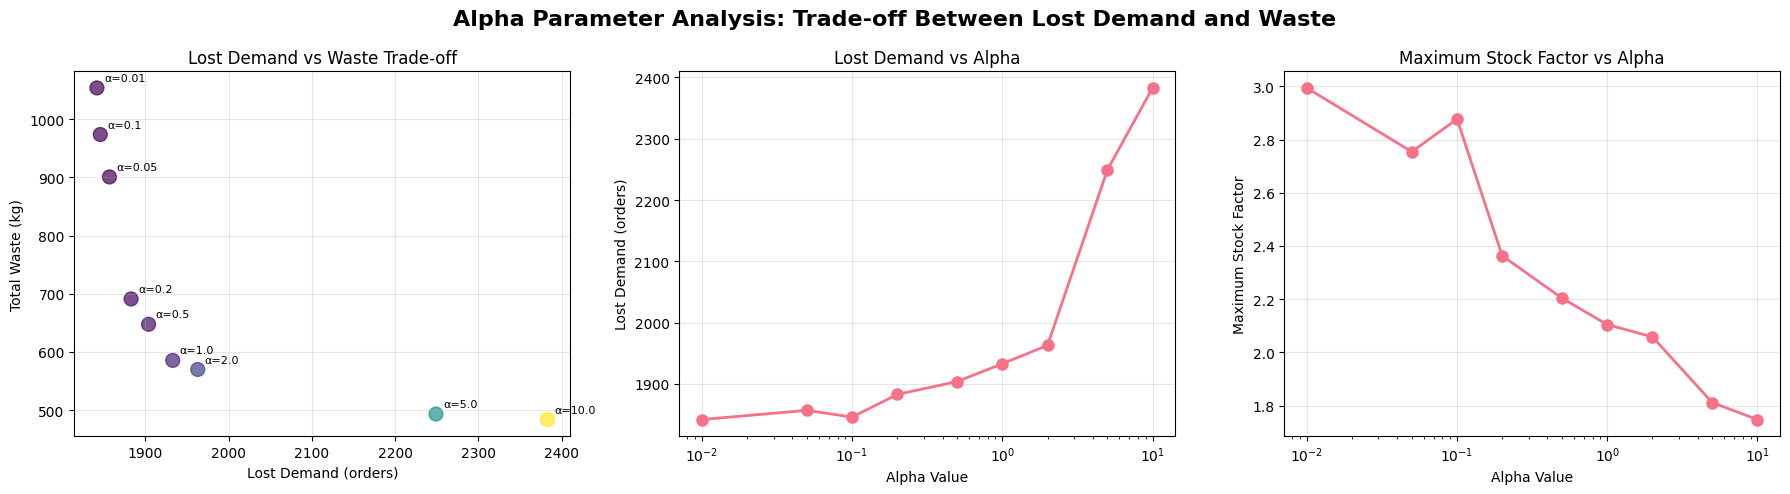

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comprehensive Visualization of Alpha Analysis Results
def create_alpha_visualizations_modified(alpha_results):
    """Create visualizations for alpha analysis (remove plots 4, 5, 6)."""

    plt.style.use('default')
    sns.set_palette("husl")

    # 3 panels: (1) Lost Demand vs Waste, (3) Lost Demand vs Alpha, (7) Max Factor vs Alpha
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Alpha Parameter Analysis: Trade-off Between Lost Demand and Waste', fontsize=16, fontweight='bold')

    # 1. Lost Demand vs Waste
    ax1 = axes[0]
    ax1.scatter(
        alpha_results['lost_demand'],
        alpha_results['waste_total_kg'],
        c=alpha_results['alpha'],
        s=100,
        cmap='viridis',
        alpha=0.7
    )
    ax1.set_xlabel('Lost Demand (orders)')
    ax1.set_ylabel('Total Waste (kg)')
    ax1.set_title('Lost Demand vs Waste Trade-off')
    ax1.grid(True, alpha=0.3)
    for _, row in alpha_results.iterrows():
        ax1.annotate(
            f'α={row["alpha"]}',
            (row['lost_demand'], row['waste_total_kg']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )

    # 3. Alpha vs Lost Demand
    ax3 = axes[1]
    ax3.plot(alpha_results['alpha'], alpha_results['lost_demand'], 'o-', linewidth=2, markersize=8)
    ax3.set_xlabel('Alpha Value')
    ax3.set_ylabel('Lost Demand (orders)')
    ax3.set_title('Lost Demand vs Alpha')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)

    # 7. Max Factor
    ax7 = axes[2]
    ax7.plot(alpha_results['alpha'], alpha_results['max_factor'], 'o-', linewidth=2, markersize=8)
    ax7.set_xlabel('Alpha Value')
    ax7.set_ylabel('Maximum Stock Factor')
    ax7.set_title('Maximum Stock Factor vs Alpha')
    ax7.set_xscale('log')
    ax7.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return fig

# Use the modified visualization function
if 'alpha_results' in globals():
    fig_modified = create_alpha_visualizations_modified(alpha_results)
else:
    print("alpha_results not found — run the optimization first.")


In [46]:
# Full Year Analysis - Table and Summary Only (No Visualizations)
def run_full_year_analysis_table_only(alpha_results: pd.DataFrame) -> pd.DataFrame:
    """
    Run simulation for the full year using the best parameters from each alpha.
    Returns only table data without visualizations.
    """
    print("Running full year analysis with optimized parameters...")
    print("=" * 80)

    full_year_results = []

    for _, row in alpha_results.iterrows():
        alpha = row["alpha"]
        print(f"Analyzing alpha = {alpha}...")

        # Create inventory parameters using the optimized factors
        def create_optimized_params(init_factor: float, min_factor: float, max_factor: float) -> pd.DataFrame:
            first_two_weeks = daily_ingredient_usage[
                (daily_ingredient_usage.index >= "2015-01-01")
                & (daily_ingredient_usage.index < "2015-01-15")
            ]
            first_three_months = daily_ingredient_usage[
                (daily_ingredient_usage.index >= "2015-01-01")
                & (daily_ingredient_usage.index < "2015-04-01")
            ]

            inventory_parameters = []
            for ingredient in daily_ingredient_usage.columns:
                initial_stock = first_two_weeks[ingredient].sum() * init_factor
                max_daily_demand = first_three_months[ingredient].max()
                max_stock = max_daily_demand * max_factor
                min_stock = max_daily_demand * min_factor
                shelf_life = shelf_life_days.get(ingredient, 7)

                inventory_parameters.append(
                    {
                        "ingredient": ingredient,
                        "initial_stock_kg": initial_stock,
                        "max_stock_kg": max_stock,
                        "min_stock_kg": min_stock,
                        "shelf_life_days": shelf_life,
                        "mass_per_pizza_kg": ingredient_masses_kg.get(ingredient, 0),
                    }
                )
            return pd.DataFrame(inventory_parameters).set_index("ingredient")

        # Create parameters with optimized factors
        optimized_params = create_optimized_params(
            float(row["init_factor"]),
            float(row["min_factor"]),
            float(row["max_factor"]),
        )

        # Run simulation for full year
        full_year_result = simulate_inventory(
            df=df,
            inventory_parameters=optimized_params,
            recipes_dict=recipes_dict,
            ingredient_masses_kg=ingredient_masses_kg,
            start_date="2015-01-01",
            end_date="2015-12-31",  # Full year
            restock_interval_days=5,
            alarm_threshold=2,
        )

        # Calculate percentages
        total_orders = float(df["quantity"].sum())
        waste_percentage = (full_year_result["waste_total_kg"] / float(grand_total_usage)) * 100.0
        lost_demand_percentage = (full_year_result["lost_demand"] / total_orders) * 100.0

        # Store results
        combined_score = full_year_result["lost_demand"] + alpha * full_year_result["waste_total_kg"]
        result_data = {
            "alpha": alpha,
            "init_factor": float(row["init_factor"]),
            "min_factor": float(row["min_factor"]),
            "max_factor": float(row["max_factor"]),
            "lost_demand": full_year_result["lost_demand"],
            "lost_demand_percentage": lost_demand_percentage,
            "waste_total_kg": full_year_result["waste_total_kg"],
            "waste_percentage": waste_percentage,
            "restock_events": full_year_result["restock_events"],
            "safety_stock_alarms": full_year_result["safety_stock_alarms"],
            "final_restock_interval": full_year_result["final_restock_interval_days"],
            "combined_score": combined_score,
        }

        full_year_results.append(result_data)

        print(f"  Lost demand: {full_year_result['lost_demand']:,} orders ({lost_demand_percentage:.2f}%)")
        print(f"  Waste: {full_year_result['waste_total_kg']:.1f} kg ({waste_percentage:.2f}%)")
        print(f"  Combined score: {combined_score:.1f}\n")

    return pd.DataFrame(full_year_results)


def create_full_year_summary_only(full_year_results: pd.DataFrame) -> pd.DataFrame:
    """Create detailed summary table of full year results without visualizations."""
    print("=" * 100)
    print("FULL YEAR ANALYSIS SUMMARY")
    print("=" * 100)

    # Display results table
    display_cols = [
        "alpha",
        "lost_demand",
        "lost_demand_percentage",
        "waste_total_kg",
        "waste_percentage",
        "combined_score",
        "restock_events",
        "safety_stock_alarms",
        "init_factor",
        "min_factor",
        "max_factor",
    ]
    summary_display = full_year_results[display_cols].round(2)
    print(summary_display.to_string(index=False))

    print("\n" + "=" * 100)
    print("KEY PERFORMANCE INDICATORS")
    print("=" * 100)

    # Find best performers
    best_lost_demand = full_year_results.loc[full_year_results["lost_demand"].idxmin()]
    best_waste = full_year_results.loc[full_year_results["waste_total_kg"].idxmin()]
    best_combined = full_year_results.loc[full_year_results["combined_score"].idxmin()]

    print("BEST FOR MINIMIZING LOST DEMAND:")
    print(
        f"  Alpha: {best_lost_demand['alpha']}\n"
        f"  Lost demand: {best_lost_demand['lost_demand']:,} orders ({best_lost_demand['lost_demand_percentage']:.2f}%)\n"
        f"  Waste: {best_lost_demand['waste_total_kg']:.1f} kg ({best_lost_demand['waste_percentage']:.2f}%)\n"
        f"  Parameters: init={best_lost_demand['init_factor']:.2f}, min={best_lost_demand['min_factor']:.2f}, max={best_lost_demand['max_factor']:.2f}"
    )
    print()

    print("BEST FOR MINIMIZING WASTE:")
    print(
        f"  Alpha: {best_waste['alpha']}\n"
        f"  Lost demand: {best_waste['lost_demand']:,} orders ({best_waste['lost_demand_percentage']:.2f}%)\n"
        f"  Waste: {best_waste['waste_total_kg']:.1f} kg ({best_waste['waste_percentage']:.2f}%)\n"
        f"  Parameters: init={best_waste['init_factor']:.2f}, min={best_waste['min_factor']:.2f}, max={best_waste['max_factor']:.2f}"
    )
    print()

    print("BEST OVERALL (LOWEST COMBINED SCORE):")
    print(
        f"  Alpha: {best_combined['alpha']}\n"
        f"  Lost demand: {best_combined['lost_demand']:,} orders ({best_combined['lost_demand_percentage']:.2f}%)\n"
        f"  Waste: {best_combined['waste_total_kg']:.1f} kg ({best_combined['waste_percentage']:.2f}%)\n"
        f"  Combined score: {best_combined['combined_score']:.1f}\n"
        f"  Parameters: init={best_combined['init_factor']:.2f}, min={best_combined['min_factor']:.2f}, max={best_combined['max_factor']:.2f}"
    )
    print()

    return summary_display


# Run the streamlined full year analysis (table and summary only)
if 'alpha_results' in globals():
    print("Running full year analysis - table and summary only...")
    full_year_results = run_full_year_analysis_table_only(alpha_results)
    full_year_summary = create_full_year_summary_only(full_year_results)
else:
    print("alpha_results not found - you may need to run the optimization first")


Running full year analysis - table and summary only...
Running full year analysis with optimized parameters...
Analyzing alpha = 0.01...
  Lost demand: 5,970 orders (12.04%)
  Waste: 3464.5 kg (20.46%)
  Combined score: 6004.6

Analyzing alpha = 0.05...
  Lost demand: 6,031 orders (12.17%)
  Waste: 2798.1 kg (16.53%)
  Combined score: 6170.9

Analyzing alpha = 0.1...
  Lost demand: 5,985 orders (12.07%)
  Waste: 3126.1 kg (18.46%)
  Combined score: 6297.6

Analyzing alpha = 0.2...
  Lost demand: 6,220 orders (12.55%)
  Waste: 1894.2 kg (11.19%)
  Combined score: 6598.8

Analyzing alpha = 0.5...
  Lost demand: 6,390 orders (12.89%)
  Waste: 1621.6 kg (9.58%)
  Combined score: 7200.8

Analyzing alpha = 1.0...
  Lost demand: 6,616 orders (13.35%)
  Waste: 1431.5 kg (8.45%)
  Combined score: 8047.5

Analyzing alpha = 2.0...
  Lost demand: 6,750 orders (13.62%)
  Waste: 1359.8 kg (8.03%)
  Combined score: 9469.6

Analyzing alpha = 5.0...
  Lost demand: 8,172 orders (16.48%)
  Waste: 1027.5 

In [42]:
import pandas as pd

# Comprehensive Analysis: Benchmark vs Two Optimized Scenarios
# Scenario 1: Minimize Lost Demand | Scenario 2: Minimize Waste

def run_two_scenario_comparison():
    """
    Compare benchmark vs two optimized scenarios:
    1. Best for minimizing lost demand (Alpha: 0.01)
    2. Best for minimizing waste (Alpha: 10.0)
    """

    print("=" * 80)
    print("INVENTORY OPTIMIZATION: TWO-SCENARIO ANALYSIS")
    print("=" * 80)
    print()

    def create_custom_params(init_factor, min_factor, max_factor, scenario_name):
        """Create inventory parameters with custom factors"""
        first_two_weeks = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') &
            (daily_ingredient_usage.index <  '2015-01-15')
        ]
        first_three_months = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') &
            (daily_ingredient_usage.index <  '2015-04-01')
        ]

        inventory_rows = []
        for ingredient in daily_ingredient_usage.columns:
            initial_stock = first_two_weeks[ingredient].sum() * float(init_factor)
            max_daily_demand = float(first_three_months[ingredient].max())
            max_stock = max_daily_demand * float(max_factor)
            min_stock = max_daily_demand * float(min_factor)
            shelf_life = shelf_life_days.get(ingredient, 7)

            inventory_rows.append({
                'ingredient': ingredient,
                'initial_stock_kg': initial_stock,
                'max_stock_kg': max_stock,
                'min_stock_kg': min_stock,
                'shelf_life_days': shelf_life,
                'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0.0)
            })

        return pd.DataFrame(inventory_rows).set_index('ingredient')

    # Create parameter sets for all scenarios
    benchmark_params = inventory_parameters  # Original parameters

    # Scenario 1: Minimize Lost Demand (Alpha: 0.01)
    min_lost_demand_params = create_custom_params(1.01, 0.28, 2.99, "Min Lost Demand")

    # Scenario 2: Minimize Waste (Alpha: 10.0)
    min_waste_params = create_custom_params(1.01, 0.15, 1.75, "Min Waste")

    # Simulation configurations
    simulation_configs = [
        # 3-Month Period
        {"name": "3M - Benchmark",        "params": benchmark_params,      "start": "2015-01-01", "end": "2015-04-01", "scenario": "Benchmark"},
        {"name": "3M - Min Lost Demand",  "params": min_lost_demand_params,"start": "2015-01-01", "end": "2015-04-01", "scenario": "Min Lost Demand"},
        {"name": "3M - Min Waste",        "params": min_waste_params,      "start": "2015-01-01", "end": "2015-04-01", "scenario": "Min Waste"},

        # Full Year
        {"name": "1Y - Benchmark",        "params": benchmark_params,      "start": "2015-01-01", "end": "2015-12-31", "scenario": "Benchmark"},
        {"name": "1Y - Min Lost Demand",  "params": min_lost_demand_params,"start": "2015-01-01", "end": "2015-12-31", "scenario": "Min Lost Demand"},
        {"name": "1Y - Min Waste",        "params": min_waste_params,      "start": "2015-01-01", "end": "2015-12-31", "scenario": "Min Waste"},
    ]

    results = []
    print("Running simulations for all scenarios...")

    for config in simulation_configs:
        print(f"  - {config['name']}")
        result = simulate_inventory(
            df=df,
            inventory_parameters=config['params'],
            recipes_dict=recipes_dict,
            ingredient_masses_kg=ingredient_masses_kg,
            start_date=config['start'],
            end_date=config['end'],
            restock_interval_days=5,
            alarm_threshold=2
        )

        # Calculate period-specific metrics
        period_orders = float(
            df[(df['order_date'] >= config['start']) & (df['order_date'] < config['end'])]['quantity'].sum()
        )
        period_ingredient_usage = float(
            daily_ingredient_usage[
                (daily_ingredient_usage.index >= config['start']) &
                (daily_ingredient_usage.index <  config['end'])
            ].sum().sum()
        )

        result.update({
            'name': config['name'],
            'scenario': config['scenario'],
            'period': '3-Month' if '3M' in config['name'] else 'Full-Year',
            'period_orders': period_orders,
            'period_ingredient_usage': period_ingredient_usage,
            'lost_demand_percentage': (result['lost_demand'] / period_orders) * 100 if period_orders else 0.0,
            'waste_percentage': (result['waste_total_kg'] / period_ingredient_usage) * 100 if period_ingredient_usage else 0.0
        })
        results.append(result)

    # Create comprehensive results DataFrame
    results_df = pd.DataFrame(results)

    print("\n" + "=" * 80)
    print("COMPREHENSIVE PERFORMANCE COMPARISON")
    print("=" * 80)

    # Format and display results table
    display_df = results_df[['name', 'lost_demand', 'lost_demand_percentage',
                             'waste_total_kg', 'waste_percentage',
                             'restock_events', 'safety_stock_alarms']].copy()
    display_df = display_df.round(2)
    print(display_df.to_string(index=False))

    # Calculate improvements for each scenario
    print("\n" + "=" * 80)
    print("SCENARIO PERFORMANCE ANALYSIS")
    print("=" * 80)

    def calculate_improvements(period_label):
        period_results = results_df[results_df['period'] == period_label]
        benchmark = period_results[period_results['scenario'] == 'Benchmark'].iloc[0]
        min_lost = period_results[period_results['scenario'] == 'Min Lost Demand'].iloc[0]
        min_waste = period_results[period_results['scenario'] == 'Min Waste'].iloc[0]

        print(f"\n{period_label.upper()} PERIOD ANALYSIS:")
        print("-" * 40)

        # Min Lost Demand Scenario
        lost_demand_improvement = ((benchmark['lost_demand'] - min_lost['lost_demand']) / benchmark['lost_demand']) * 100 if benchmark['lost_demand'] else 0.0
        waste_change = ((min_lost['waste_total_kg'] - benchmark['waste_total_kg']) / benchmark['waste_total_kg']) * 100 if benchmark['waste_total_kg'] else 0.0

        print("📉 SCENARIO 1 - MINIMIZE LOST DEMAND:")
        print(f"   Lost Demand: {benchmark['lost_demand']:.0f} → {min_lost['lost_demand']:.0f} orders ({lost_demand_improvement:+.1f}%)")
        print(f"   Waste: {benchmark['waste_total_kg']:.1f} → {min_lost['waste_total_kg']:.1f} kg ({waste_change:+.1f}%)")
        print("   Parameters: init=1.01, min=0.28, max=2.99")

        # Min Waste Scenario
        waste_improvement = ((benchmark['waste_total_kg'] - min_waste['waste_total_kg']) / benchmark['waste_total_kg']) * 100 if benchmark['waste_total_kg'] else 0.0
        lost_demand_change = ((min_waste['lost_demand'] - benchmark['lost_demand']) / benchmark['lost_demand']) * 100 if benchmark['lost_demand'] else 0.0

        print("\n♻️  SCENARIO 2 - MINIMIZE WASTE:")
        print(f"   Lost Demand: {benchmark['lost_demand']:.0f} → {min_waste['lost_demand']:.0f} orders ({lost_demand_change:+.1f}%)")
        print(f"   Waste: {benchmark['waste_total_kg']:.1f} → {min_waste['waste_total_kg']:.1f} kg ({waste_improvement:+.1f}%)")
        print("   Parameters: init=1.01, min=0.15, max=1.75")

        return {
            'period': period_label,
            'benchmark': benchmark,
            'min_lost': min_lost,
            'min_waste': min_waste,
            'lost_demand_improvement': lost_demand_improvement,
            'waste_improvement': waste_improvement
        }

    # Analyze both periods
    three_month_analysis = calculate_improvements('3-Month')
    full_year_analysis = calculate_improvements('Full-Year')

    # Restaurant Owner Guidance
    print("\n" + "=" * 80)
    print("RESTAURANT OWNER DECISION GUIDE")
    print("=" * 80)

    print("🎯 CHOOSE YOUR OPTIMIZATION STRATEGY:\n")
    print("📉 SCENARIO 1 - CUSTOMER SATISFACTION FOCUSED:")
    print("   • Priority: Minimize lost sales and maximize customer satisfaction")
    print("   • Trade-off: Higher food waste costs but better service reliability")
    print("   • Best for: High-margin restaurants, peak season operations, reputation-focused establishments")
    print("   • Inventory Setup:")
    print("     - Initial Stock: 1.01x your 2-week demand forecast")
    print("     - Reorder Point: 0.28x maximum daily demand (higher safety margins)")
    print("     - Maximum Stock: 2.99x maximum daily demand (larger buffers)\n")

    print("♻️  SCENARIO 2 - COST EFFICIENCY FOCUSED:")
    print("   • Priority: Minimize waste and reduce operational costs")
    print("   • Trade-off: Some lost sales but significantly lower waste disposal costs")
    print("   • Best for: Cost-conscious operations, stable demand periods, sustainability-focused restaurants")
    print("   • Inventory Setup:")
    print("     - Initial Stock: 1.01x your 2-week demand forecast")
    print("     - Reorder Point: 0.15x maximum daily demand (tighter inventory)")
    print("     - Maximum Stock: 1.75x maximum daily demand (smaller buffers)\n")

    # Financial Impact Analysis
    avg_pizza_price = df["unit_price"].median()
    waste_cost_per_kg = 14

    print("💰 ANNUAL FINANCIAL IMPACT COMPARISON:")
    fy_benchmark = full_year_analysis['benchmark']
    fy_min_lost = full_year_analysis['min_lost']
    fy_min_waste = full_year_analysis['min_waste']

    # Scenario 1 Financial Impact
    scenario1_lost_sales_recovery = (fy_benchmark['lost_demand'] - fy_min_lost['lost_demand']) * avg_pizza_price
    scenario1_waste_cost_increase = (fy_min_lost['waste_total_kg'] - fy_benchmark['waste_total_kg']) * waste_cost_per_kg
    scenario1_net_benefit = scenario1_lost_sales_recovery - scenario1_waste_cost_increase

    print(f"\nScenario 1 (Min Lost Demand):")
    print(f"   Sales Recovery: +${scenario1_lost_sales_recovery:,.0f}")
    print(f"   Waste Cost Increase: -${scenario1_waste_cost_increase:,.0f}")
    print(f"   Net Annual Benefit: ${scenario1_net_benefit:,.0f}")

    # Scenario 2 Financial Impact
    scenario2_waste_savings = (fy_benchmark['waste_total_kg'] - fy_min_waste['waste_total_kg']) * waste_cost_per_kg
    scenario2_lost_sales_cost = (fy_min_waste['lost_demand'] - fy_benchmark['lost_demand']) * avg_pizza_price
    scenario2_net_benefit = scenario2_waste_savings - scenario2_lost_sales_cost

    print(f"\nScenario 2 (Min Waste):")
    print(f"   Waste Savings: +${scenario2_waste_savings:,.0f}")
    print(f"   Lost Sales Cost: -${scenario2_lost_sales_cost:,.0f}")
    print(f"   Net Annual Benefit: ${scenario2_net_benefit:,.0f}")

    # Implementation recommendations
    print("\n🔧 IMPLEMENTATION RECOMMENDATIONS:")
    if scenario1_net_benefit > scenario2_net_benefit:
        print("   ✅ RECOMMENDED: Scenario 1 (Minimize Lost Demand)")
        print(f"   • Higher net benefit: ${scenario1_net_benefit:,.0f} vs ${scenario2_net_benefit:,.0f}")
        print("   • Focus on customer satisfaction and sales growth")
    else:
        print("   ✅ RECOMMENDED: Scenario 2 (Minimize Waste)")
        print(f"   • Higher net benefit: ${scenario2_net_benefit:,.0f} vs ${scenario1_net_benefit:,.0f}")
        print("   • Focus on operational efficiency and cost control")

    print("\n📋 OPERATIONAL PROCEDURES (BOTH SCENARIOS):")
    print("   1. Implement FEFO (First-Expired-First-Out) rotation")
    print("   2. Daily expiration monitoring and removal")
    print("   3. Automated restock scheduling every 5 days + weekly deliveries")
    print("   4. Staff training on inventory management procedures")
    print("   5. Regular performance monitoring and parameter adjustment")

    return results_df


# Run the two-scenario analysis
if 'inventory_parameters' in globals() and 'daily_ingredient_usage' in globals():
    two_scenario_results = run_two_scenario_comparison()
else:
    print("Required data not found. Please run the previous cells first.")


INVENTORY OPTIMIZATION: TWO-SCENARIO ANALYSIS

Running simulations for all scenarios...
  - 3M - Benchmark
  - 3M - Min Lost Demand
  - 3M - Min Waste
  - 1Y - Benchmark
  - 1Y - Min Lost Demand
  - 1Y - Min Waste

COMPREHENSIVE PERFORMANCE COMPARISON
                name  lost_demand  lost_demand_percentage  waste_total_kg  waste_percentage  restock_events  safety_stock_alarms
      3M - Benchmark         5493                   44.11         1174.58             27.58              39                 3514
3M - Min Lost Demand         1842                   14.79         1053.20             24.73              39                  229
      3M - Min Waste         2380                   19.11          483.06             11.34              39                  387
      1Y - Benchmark        21894                   44.32         1306.54              7.74             156                15145
1Y - Min Lost Demand         5971                   12.09         3454.94             20.48            

In [40]:
import pandas as pd
from datetime import datetime, timedelta

# Simulation parameters
start_date = datetime(2015, 1, 1).date()
end_date = datetime(2015, 4, 1).date()
restock_interval_days = 5

print("RESTOCK SCHEDULE FOR FIRST THREE MONTHS (Jan 1 - Mar 31, 2015)")
print("=" * 60)

# Generate all days in the period
days = pd.date_range(start_date, end_date - timedelta(days=1), freq="D").date

restock_days = []

for day in days:
    restock_today = False
    restock_type = None

    # Weekly Monday restock
    if day.weekday() == 0:  # Monday = 0
        restock_today = True
        restock_type = "Weekly (Monday)"

    # Interval-based restock (every 5 days from start)
    days_since_start = (day - start_date).days
    if days_since_start % restock_interval_days == 0:
        if restock_today:
            restock_type = "Both Weekly + Interval"
        else:
            restock_today = True
            restock_type = "Interval (5-day)"

    if restock_today:
        restock_days.append({
            "Date": day,
            "Day_of_Week": day.strftime("%A"),
            "Days_from_Start": days_since_start,
            "Restock_Type": restock_type
        })

# Create DataFrame for better display
restock_df = pd.DataFrame(restock_days)

print("RESTOCK DAYS:")
print(restock_df.to_string(index=False))

print("\nSUMMARY:")
print(f"Total restock days in 3 months: {len(restock_days)}")
print(f"Weekly restocks (Mondays): {len([r for r in restock_days if 'Weekly' in r['Restock_Type']])}")
print(f"Interval-only restocks: {len([r for r in restock_days if r['Restock_Type'] == 'Interval (5-day)'])}")
print(f"Combined days (both triggers): {len([r for r in restock_days if 'Both' in r['Restock_Type']])}")


RESTOCK SCHEDULE FOR FIRST THREE MONTHS (Jan 1 - Mar 31, 2015)
RESTOCK DAYS:
      Date Day_of_Week  Days_from_Start           Restock_Type
2015-01-01    Thursday                0       Interval (5-day)
2015-01-05      Monday                4        Weekly (Monday)
2015-01-06     Tuesday                5       Interval (5-day)
2015-01-11      Sunday               10       Interval (5-day)
2015-01-12      Monday               11        Weekly (Monday)
2015-01-16      Friday               15       Interval (5-day)
2015-01-19      Monday               18        Weekly (Monday)
2015-01-21   Wednesday               20       Interval (5-day)
2015-01-26      Monday               25 Both Weekly + Interval
2015-01-31    Saturday               30       Interval (5-day)
2015-02-02      Monday               32        Weekly (Monday)
2015-02-05    Thursday               35       Interval (5-day)
2015-02-09      Monday               39        Weekly (Monday)
2015-02-10     Tuesday               40  